[*********************100%***********************]  11 of 11 completed


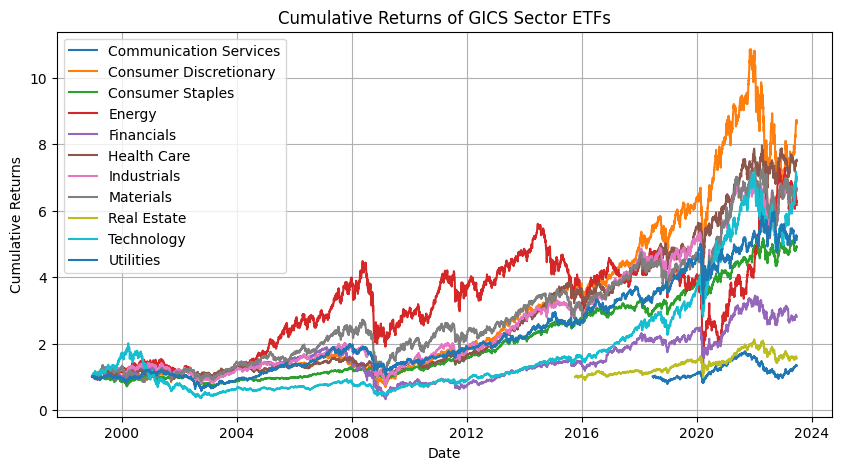

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of GICS Sector ETFs
sector_etfs = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities"
}

data = yf.download(list(sector_etfs.keys()))

# Calculate the cumulative returns
cumulative_returns = (1 + data['Adj Close'].pct_change()).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10,5))
for etf, sector in sector_etfs.items():
    plt.plot(cumulative_returns.index, cumulative_returns[etf], label=sector)

plt.title("Cumulative Returns of GICS Sector ETFs")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid()
plt.show()


[*********************100%***********************]  11 of 11 completed


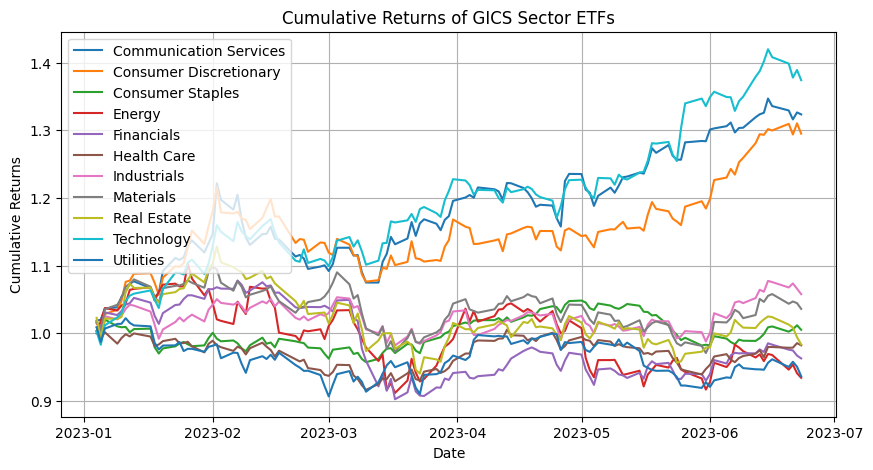

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of GICS Sector ETFs
sector_etfs = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities"
}

data = yf.download(list(sector_etfs.keys()), start="2023-01-01")

# Calculate the cumulative returns
cumulative_returns = (1 + data['Adj Close'].pct_change()).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10,5))
for etf, sector in sector_etfs.items():
    plt.plot(cumulative_returns.index, cumulative_returns[etf], label=sector)

plt.title("Cumulative Returns of GICS Sector ETFs")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid()
plt.show()


[*********************100%***********************]  11 of 11 completed


C:\Users\mehdi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_20808\967033971.py:59: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  growth_indicator = pd.Series(index=etf_oil_log_ratio.index)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_20808\967033971.py:118: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  inflation_indicator = ((monthly_inflation > 0) & (dgs10 > 2)).astype(int).resample('D').pad()


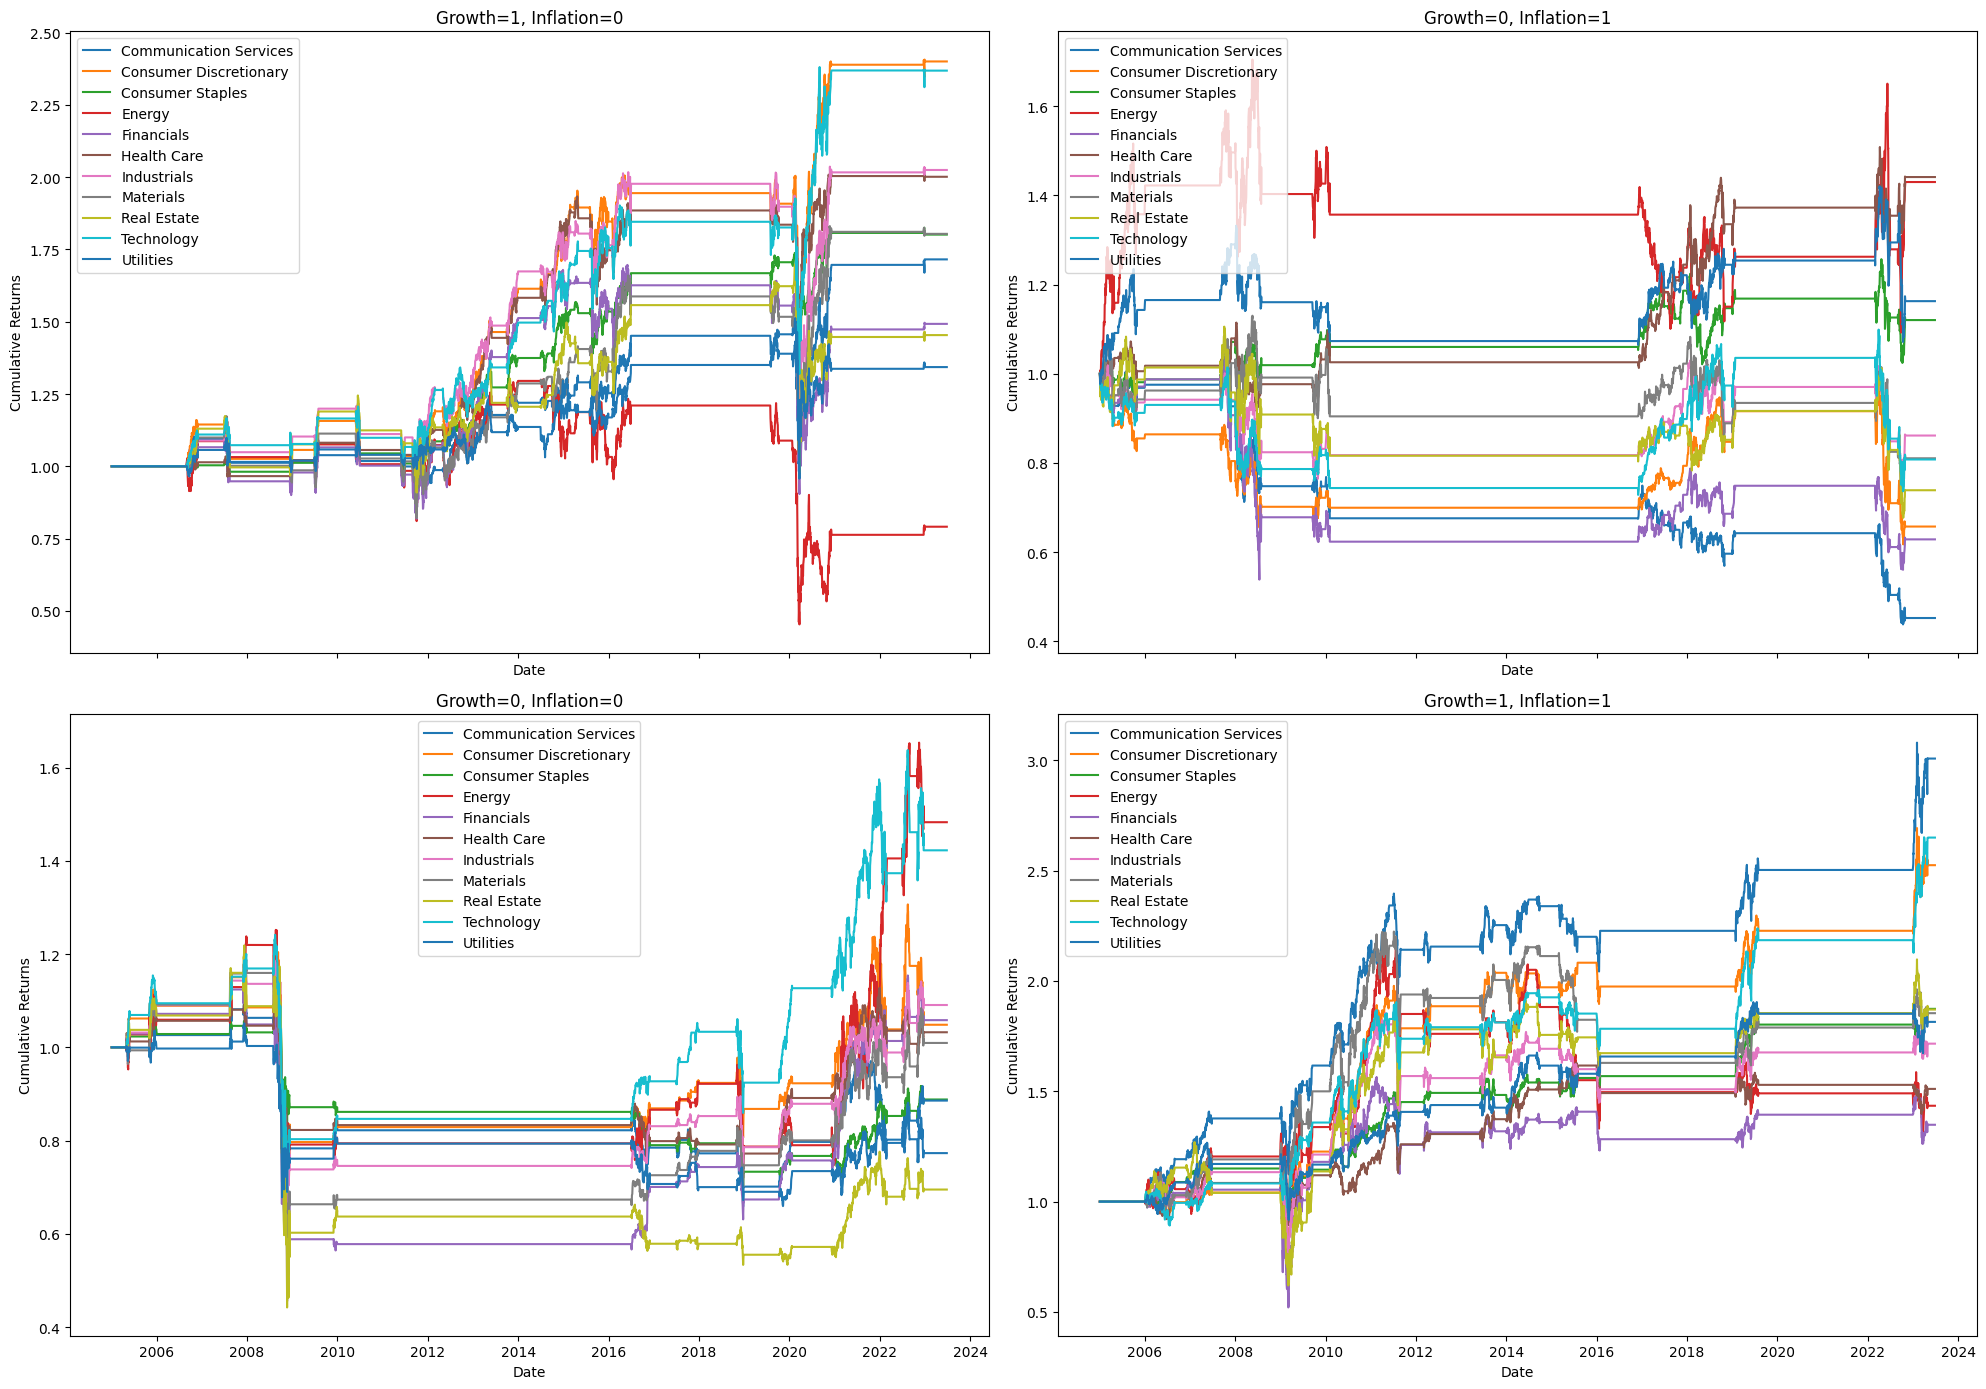

In [16]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression


def convert_date_to_ordinal(date):
    return date.toordinal()


def calculate_slope(X, y):
    """Fit a linear regression model and return the slope"""
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]


# Define sector ETFs and their names
sector_etfs = ["VOX", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "IYR", "XLK", "XLU"]
sector_names = {
    "VOX": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "IYR": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities"
}

# Fetch ETF data
etfs_data = yf.download(sector_etfs, start='2005-01-01')
etf_close = etfs_data["Close"]

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch WTI Crude Oil Price data
oil_price = fred.get_series('DCOILWTICO')

# Remove or fill in missing values
etf_close = etf_close.dropna()
oil_price = oil_price.dropna()

# Calculate the logarithms
etf_log = np.log(etf_close)
oil_log = np.log(oil_price)

# Compute the ratio of the logarithm of ETF prices and oil price
etf_oil_log_ratio = (etf_log).div(oil_log, axis=0)

# Initialize the indicator series
growth_indicator = pd.Series(index=etf_oil_log_ratio.index)

# Compute the 1-year and 7-year slopes for each day
for date in etf_oil_log_ratio.index:
    # Compute the 1-year slope
    one_year_ago = date - DateOffset(years=1)
    last_year_log_ratio = etf_oil_log_ratio[
        (etf_oil_log_ratio.index >= one_year_ago) & (etf_oil_log_ratio.index < date)]

    if not last_year_log_ratio.empty:
        X1 = np.array(last_year_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_log_ratio.mean(axis=1).values

        # Handle NaN values
        valid_indices = ~np.isnan(y1)
        X1 = X1[valid_indices]
        y1 = y1[valid_indices]

        if len(y1) > 0:
            one_year_slope = calculate_slope(X1, y1)

            # Compute the 7-year slope
            seven_years_ago = date - DateOffset(years=7)
            last_seven_years_log_ratio = etf_oil_log_ratio[
                (etf_oil_log_ratio.index >= seven_years_ago) & (etf_oil_log_ratio.index < date)]

            if not last_seven_years_log_ratio.empty:
                X7 = np.array(last_seven_years_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
                y7 = last_seven_years_log_ratio.mean(axis=1).values

                # Handle NaN values
                valid_indices = ~np.isnan(y7)
                X7 = X7[valid_indices]
                y7 = y7[valid_indices]

                if len(y7) > 0:
                    seven_year_slope = calculate_slope(X7, y7)

                    # Compute the indicator
                    if one_year_slope > seven_year_slope:
                        growth_indicator[date] = 1
                    else:
                        growth_indicator[date] = 0

# Fetch CPI data from FRED
cpi = fred.get_series("CPIAUCNS")

# Calculate monthly inflation rate
monthly_inflation = cpi.pct_change()

# Create DataFrame for combined strategy backtesting
backtest_data = etf_close.copy()
backtest_data["growth_indicator"] = growth_indicator

# Fetch 10 year constant maturity yield rate
dgs10 = fred.get_series('GS10', observation_start='2005-01-01')
backtest_data['dgs10'] = dgs10

# Compute the indicator for the inflation strategy
inflation_indicator = ((monthly_inflation > 0) & (dgs10 > 2)).astype(int).resample('D').pad()
backtest_data["inflation_indicator"] = inflation_indicator

# Combined indicator - both growth and inflation indicators are 1
backtest_data['combined_indicator'] = (backtest_data['growth_indicator'] == 1) & (backtest_data['inflation_indicator'] == 1)

# Calculate the daily returns when both indicators are 1 for each sector
for sector in sector_etfs:
    backtest_data[f'daily_returns_combined_{sector}'] = backtest_data[sector].pct_change() * (backtest_data['combined_indicator'])


def calculate_and_plot_cumulative_returns(data, sector_etfs, sector_names, growth_indicator, inflation_indicator, subplot, title):
    daily_returns_columns = {}
    cumulative_returns_columns = {}

    # Calculate the daily returns based on the given indicators
    for sector in sector_etfs:
        column_name = f'daily_returns_{growth_indicator}_{inflation_indicator}_{sector}'
        daily_returns_columns[column_name] = data[sector].pct_change() * ((data['growth_indicator'] == growth_indicator) & (data['inflation_indicator'] == inflation_indicator))

    # Concatenate all daily return columns at once
    daily_returns_df = pd.concat(daily_returns_columns, axis=1)
    data = pd.concat([data, daily_returns_df], axis=1)

    # Calculate and plot the cumulative returns based on the given indicators
    for sector, sector_name in sector_names.items():
        column_name = f'cumulative_returns_{growth_indicator}_{inflation_indicator}_{sector}'
        cumulative_returns_columns[column_name] = (1 + daily_returns_columns[f'daily_returns_{growth_indicator}_{inflation_indicator}_{sector}'].fillna(0)).cumprod()

    # Concatenate all cumulative return columns at once
    cumulative_returns_df = pd.concat(cumulative_returns_columns, axis=1)
    data = pd.concat([data, cumulative_returns_df], axis=1)

    for sector, sector_name in sector_names.items():
        subplot.plot(data[f'cumulative_returns_{growth_indicator}_{inflation_indicator}_{sector}'], label=sector_name)

    subplot.set_title(title)
    subplot.set_xlabel('Date')
    subplot.set_ylabel('Cumulative Returns')
    subplot.legend()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14), sharex=True)

# Plot cumulative returns for different combinations of indicators
calculate_and_plot_cumulative_returns(backtest_data, sector_etfs, sector_names, 1, 0, axes[0, 0], 'Growth=1, Inflation=0')
calculate_and_plot_cumulative_returns(backtest_data, sector_etfs, sector_names, 0, 1, axes[0, 1], 'Growth=0, Inflation=1')
calculate_and_plot_cumulative_returns(backtest_data, sector_etfs, sector_names, 0, 0, axes[1, 0], 'Growth=0, Inflation=0')
calculate_and_plot_cumulative_returns(backtest_data, sector_etfs, sector_names, 1, 1, axes[1, 1], 'Growth=1, Inflation=1')

plt.tight_layout()
plt.show()







